In [23]:
from cpmpy import *
## torch for training neural network
import torch
from torch import nn, optim
import torch.utils.data as data_utils
import numpy as np
import pandas as pd
## sklean module for data transforming and model running
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
import sklearn
#seaborn for creating nice plot
import seaborn as sns
import time
from tqdm import tqdm
# sns.set_theme()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
import os
## tensorboard to look at learning curve
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import learning_curve
writer = SummaryWriter('runs/CPMPY')
%load_ext tensorboard

#### First we  load the data. We have training and test data.

In [5]:
if not os.path.exists('Data.npz'):
    torch.hub.download_url_to_file("https://github.com/JayMan91/aaai_predit_then_optimize/raw/master/Data.npz", "Data.npz")
data = np.load("Data.npz")
x_train,  x_test, y_train,y_test = data['X_1gtrain'],data['X_1gtest'],data['y_train'],data['y_test']
x_train = x_train[:,1:]
x_test = x_test[:,1:]
print(x_train.shape,x_test.shape)

(26496, 8) (11376, 8)


#### 8 features: HolidayFlag, DayOfWeek, WeekOfYear, Month, ForecastWindProduction, Forecasted SystemLoad,  Forecasted Energy price, Forecasted CO2Intensity
#### And the predictor variable: Energy Price

#### First we standardize the feature variables. We also reshape the data in groups of 48 so that each group is an instance.

In [6]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train = x_train.reshape(-1,48,x_train.shape[1])
y_train = y_train.reshape(-1,48)
x_test = x_test.reshape(-1,48,x_test.shape[1])
y_test = y_test.reshape(-1,48)
x_test = x_test[:50]
y_test = y_test[:50]
print("Number of instances in training {} and testing {}".format(x_train.shape, x_test.shape))
## we now randomize the training and test data
x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train,y_test), axis=0)
x,y = sklearn.utils.shuffle(x,y,random_state=0)

Number of instances in training (552, 48, 8) and testing (50, 48, 8)


#### As we see, we have 552 training instances and test on 50 instances.

### We will use this data in the context of knapsack problem. The predicted  Energy Price forms the value of knapsack. In our setup, each knapsack instance consists of 48 items. 

In [7]:
weights = [data['weights'].tolist()]
weights = np.array(weights)
n_items = 48
capacity = 60
print(np.sum(weights))

240


### The weights are the costs of each item. The weights are kept same for each instance. The summation of 48 weights are 240. The knapsack capacity in this example is 60

## Now, first write the knpacak solver on CPMPY

#### Now we create an wrapper object, which repeatedly solve the knapsack problem where the cost are fed as pytorch tensor

In [8]:
class problem_solver:
    def __init__(self,weights,capacity,n_items):
        self.weights = weights
        self.capacity =  capacity
        self.n_items = n_items
        self.x = boolvar(shape=n_items, name="x")
        self.model = Model(sum(self.x*weights[0]) <= capacity)
        
    def solve_knapsack(self,cost):
        cost_ = (1000*cost).astype(int)
        # We have to convert the cost variable into integer, as ORtools only accepts integer variable
        self.model.maximize((self.x*cost_).sum())
        self.model.solve()
        return self.x.value()
        
        
    def solve_from_pytorch(self,cost_inpytorch):
        # cost_inpytorch is a pytorch tensor object
        cost_ = cost_inpytorch.detach().numpy()
        x = self.solve_knapsack(cost_)
        return torch.from_numpy(x).float()

### Next, we create a solver instance with the specified weights and capacity

In [9]:
knapsack_solver = problem_solver(weights,capacity,n_items)

### The desirable goal to minimze the regret,
### Regret is the loss in the objective value for using the solution of predicted value rather than the solution of true value (which we do not know).


### If $c$ are the true values and $\hat{c}$ are the predicted values and $w^\star(c)$ and $w^\star(\hat{c})$ are their solutions. 
### Then regret $=c^\top( w^\star(c) -w^\star(\hat{c}) )$

In [10]:
## A function to compute regret
def regret_score(y,y_pred):
        total_loss =0 
        for i in range(len(y)):
            sol_true = knapsack_solver.solve_knapsack(y[i])
            sol = knapsack_solver.solve_knapsack(y_pred[i])
            total_loss +=  ((sol_true - sol).dot(y[i]))
        return total_loss/len(y)

#### We will use the sklearn module for model training and scoring. For that we need a scoring function which will compute average regret of the instances. 

In [11]:
@torch.no_grad()
def score_fucn(model,X,y):
    model.eval()
    y_pred = model(torch.from_numpy(X).float()).squeeze()
    regret = regret_score(y,y_pred)
    model.train()
    return regret

#### We will also need a dataloder module, which will segregate the training data into batches

In [12]:
class Dataloader():
    def __init__(self, X,y):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)

        
        sol = []
        for i in range(len(y)):
            x_sol = knapsack_solver.solve_knapsack(y[i])            
            sol.append( x_sol)
        self.sol = np.array(sol)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return  self.X[idx],self.y[idx],self.sol[idx]

## Two-stage Regression Model

In [13]:
class reg:
    def __init__(self, net = nn.Linear(8,1),
                 epochs=8,optim=optim.Adam,batch_size=24,lr=1,**kwg):
        self.net = net
        self.epochs = epochs
        self.batch_size = batch_size

        self.kwg = kwg
        self.optim = optim
        self.lr = lr

    def get_params(self, deep=True):
        para_dict =  {"net": self.net, "epochs": self.epochs,
        "batch_size":self.batch_size,
        "optim":self.optim,"lr":self.lr}
        return para_dict
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self,X,y):
        self.model = self.net
        self.optimizer = self.optim(self.model.parameters(),lr=self.lr, **self.kwg)
        criterion = nn.MSELoss(reduction='mean')

        train_df = Dataloader(X,y)
        fit_time= 0
        
        for e in tqdm(range(self.epochs)):
            train_dl = data_utils.DataLoader(train_df, batch_size=self.batch_size,shuffle=True)
            bb = 0
            for x_train,y_train,sol_train in train_dl:
                start_time = time.time()
                self.optimizer.zero_grad()
                y_pred = self.model(x_train).squeeze()
                loss= criterion(y_pred,y_train)
                loss.retain_grad()
                y_pred.retain_grad()
                loss.backward()                
                self.optimizer.step()
                end_training = time.time()
                ## now  we will save mse and regret and traininng data, this will take more time
                if (e+1)%3==0:
                    mse_loss =  loss.item()

                    regret_loss = regret_score(y_train.detach().numpy(),y_pred.detach().numpy())
                    end_regret = time.time()
                    fit_time += end_training - start_time
                    writer.add_scalar('Two stage MSE loss',mse_loss, e + bb/self.batch_size, fit_time)
                    writer.add_scalar('Two stage Regret',regret_loss, e + bb/self.batch_size, fit_time)
                bb =+1

    def score(self,X,y):
        return score_fucn(self.model,X,y)

    def predict(self,X):
        self.model.eval()
        y_pred = self.model(torch.from_numpy(X).float()).squeeze()
        self.model.train()
        return y_pred.detach().numpy()        



#### A wrapper module to to train and test multiple times. We will use the inbuilt cross_validate module to train and test `n_run` times.

In [14]:
def repeatrun(n_train, n_test,n_run=1):
    i = 0
    while i < n_run:
        idx1 = np.arange(0, n_train , dtype=int)
        idx2 = np.arange(n_train, n_train+n_test, dtype=int)
        yield idx1, idx2
        i += 1


### Now we will run the two-stage model and save the regret and MSE  on test and train data
#### We also monitor the leanring curve. It will take 1 minute.

In [15]:
regression_df = pd.DataFrame()
epoch=10
scoring = {'Regret': make_scorer(regret_score),
            'MSE': make_scorer(mse)}
model = reg(optim=optim.SGD, epochs=epoch,lr= 0.01)
cv = repeatrun(len(y_train),len(y_test))
scores = cross_validate(model, x,y, scoring=scoring,cv=cv, return_train_score=True)
scores = pd.DataFrame.from_dict(scores)
scores['epoch'] = epoch
regression_df = regression_df.append(scores)
regression_df['model'] ="Two-stage"
regression_df.reset_index(inplace=True)

  0%|          | 0/10 [00:00<?, ?it/s]/home/jayanta/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
100%|██████████| 10/10 [00:32<00:00,  3.23s/it]


## Smart Predict and Optimize Regression Model 

In [16]:
class SPO:
    def __init__(self, net = nn.Linear(8,1),
                 epochs=8,optim=optim.Adam,batch_size=24,lr=1,
                 **kwg):
        self.net = net
        self.epochs = epochs
        self.batch_size = batch_size
        self.kwg = kwg
        self.optim = optim
        self.lr = lr

    def get_params(self, deep=True):
        para_dict =  {"net": self.net, "epochs": self.epochs,
        "batch_size":self.batch_size,"optim":self.optim,
        "lr":self.lr}
        return para_dict
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


    def fit(self,X,y):
        self.model = self.net
        self.optimizer = self.optim(self.model.parameters(),lr=self.lr, **self.kwg)
        
        train_df = Dataloader(X,y)
        criterion = nn.MSELoss(reduction='mean')
        fit_time= 0
        
        for e in tqdm(range(self.epochs)):
            train_dl = data_utils.DataLoader(train_df, batch_size=self.batch_size,shuffle=True)
            bb = 0
            for x_train,y_train,sol_train in train_dl:
                start_time = time.time()
                self.optimizer.zero_grad()
                y_pred = self.model(x_train).squeeze()
                
                # The difference from the Two-stage approah is that,
                # the loss function considers what happen after solving the knapsack instances
                y_spo = 2*y_pred - y_train
                grad_list = []
                # we have to solve the knpsack problem for all training instances with the predicted energy price
                for i in range(len(y_train)):
                    sol_spo = knapsack_solver.solve_from_pytorch(y_spo[i])
                    # We compute the (sub)gradients directly, see SPO paper
                    grad = sol_spo - sol_train[i]
                    grad_list.append(grad)
                grad = torch.stack(grad_list,0)
                y_pred.retain_grad()
                # gradients do not come from a loss , but we use SPO subgradients   
                y_pred.backward(gradient=grad)
                # This is where SPO differes from the Two-stage model
                self.optimizer.step()
                end_training = time.time()
                ## now  we will save mse and regret and traininng data, this will take more time
                if (e+1)%3==0:
                    mse_loss = criterion(y_pred,y_train).item()
                    regret_loss = regret_score(y_train.detach().numpy(),y_pred.detach().numpy())
                    end_regret = time.time()
                    fit_time += end_training - start_time
                    writer.add_scalar('SPO MSE loss',mse_loss, e + bb/self.batch_size,fit_time)
                    writer.add_scalar('SPO Regret',regret_loss, e + bb/self.batch_size,fit_time)
                bb =+1

    def score(self,X,y):
        return score_fucn(self.model,X,y)

    def predict(self,X):
        self.model.eval()
        y_pred = self.model(torch.from_numpy(X).float()).squeeze()
        self.model.train()
        return y_pred.detach().numpy()

### Now we will run the SPO model and save the regret and MSE  on test and train data
####  We also monitor the leanring curve. It will take 2-3 minutes.

In [18]:
spo_df = pd.DataFrame()

scoring = {'Regret': make_scorer(regret_score),
            'MSE': make_scorer(mse)}
model = SPO(optim=optim.Adam, epochs=epoch,lr= 0.01)
cv = repeatrun(len(y_train),len(y_test))
scores = cross_validate(model, x,y, scoring=scoring,cv=cv, return_train_score=True)
scores = pd.DataFrame.from_dict(scores)
scores['epoch'] = epoch
spo_df = spo_df.append(scores)
spo_df['model'] ="SPO"
spo_df.reset_index(inplace=True)

100%|██████████| 10/10 [01:23<00:00,  8.34s/it]


### We will see the learning curve on tensorboard

In [28]:
%tensorboard --logdir=runs --port=6005

## For a two-stage model even though MSE goes down, regret goes up
## For SPO, Regret goes down

### Now we examine the performance on test data.

In [29]:
rslt_df =  pd.concat([spo_df,regression_df],ignore_index=True)
rslt_df.groupby(['model']).agg({'test_Regret':['mean'],'test_MSE': ['mean'],'fit_time':['mean'] })

,test_Regret,test_MSE,fit_time
,mean,mean,mean
model,,,
SPO,778.197613,143247.205448,88.768923
Two-stage,972.689750,32204.801679,37.515941


## We see, on test data, regret is significantly lower for SPO, confirming the superiority of this approach.

## Because we repeatedly call solver while training SPO model, the model fitting time is high for SPO.

### Previous Code

## Two stage model without tensorboard

In [30]:
class reg:
    def __init__(self, net = nn.Linear(8,1),
                 epochs=8,optim=optim.Adam,batch_size=24,lr=1,**kwg):
        self.net = net
        self.epochs = epochs
        self.batch_size = batch_size

        self.kwg = kwg
        self.optim = optim
        self.lr = lr

    def get_params(self, deep=True):
        para_dict =  {"net": self.net, "epochs": self.epochs,
        "batch_size":self.batch_size,
        "optim":self.optim,"lr":self.lr}
        return para_dict
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self,X,y):
        self.model = self.net
        self.optimizer = self.optim(self.model.parameters(),lr=self.lr, **self.kwg)
        criterion = nn.MSELoss(reduction='mean')

        train_df = Dataloader(X,y)
        fit_time= 0
        
        for e in range(self.epochs):
            train_dl = data_utils.DataLoader(train_df, batch_size=self.batch_size,shuffle=True)
            bb = 0
            for x_train,y_train,sol_train in train_dl:
                start_time = time.time()
                self.optimizer.zero_grad()
                y_pred = self.model(x_train).squeeze()
                loss= criterion(y_pred,y_train)
                loss.retain_grad()
                y_pred.retain_grad()
                loss.backward()                
                self.optimizer.step()
                end_training = time.time()
                bb =+1

    def score(self,X,y):
        return score_fucn(self.model,X,y)

    def predict(self,X):
        self.model.eval()
        y_pred = self.model(torch.from_numpy(X).float()).squeeze()
        self.model.train()
        return y_pred.detach().numpy()        

## SPO model without tensorboard

In [31]:
class SPO:
    def __init__(self, net = nn.Linear(8,1),
                 epochs=8,optim=optim.Adam,batch_size=24,lr=1,
                 **kwg):
        self.net = net
        self.epochs = epochs
        self.batch_size = batch_size
        self.kwg = kwg
        self.optim = optim
        self.lr = lr

    def get_params(self, deep=True):
        para_dict =  {"net": self.net, "epochs": self.epochs,
        "batch_size":self.batch_size,"optim":self.optim,
        "lr":self.lr}
        return para_dict
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


    def fit(self,X,y):
        self.model = self.net
        self.optimizer = self.optim(self.model.parameters(),lr=self.lr, **self.kwg)
        
        train_df = Dataloader(X,y)
        criterion = nn.MSELoss(reduction='mean')
        fit_time= 0
        
        for e in range(self.epochs):
            train_dl = data_utils.DataLoader(train_df, batch_size=self.batch_size,shuffle=True)
            bb = 0
            for x_train,y_train,sol_train in train_dl:
                start_time = time.time()
                self.optimizer.zero_grad()
                y_pred = self.model(x_train).squeeze()
                
                # The difference from the Two-stage approah is that,
                # the loss function considers what happen after solving the knapsack instances
                y_spo = 2*y_pred - y_train
                grad_list = []
                # we have to solve the knpsack problem for all training instances with the predicted energy price
                for i in range(len(y_train)):
                    sol_spo = knapsack_solver.solve_from_pytorch(y_spo[i])
                    # We compute the (sub)gradients directly, see SPO paper
                    grad = sol_spo - sol_train[i]
                    grad_list.append(grad)
                grad = torch.stack(grad_list,0)
                y_pred.retain_grad()
                # gradients do not come from a loss , but we use SPO subgradients   
                y_pred.backward(gradient=grad)
                # This is where SPO differes from the Two-stage model
                self.optimizer.step()
                end_training = time.time()
                bb =+1

    def score(self,X,y):
        return score_fucn(self.model,X,y)

    def predict(self,X):
        self.model.eval()
        y_pred = self.model(torch.from_numpy(X).float()).squeeze()
        self.model.train()
        return y_pred.detach().numpy()

#### First we run the two stage model for epochs 3,6 and 9. It will take 2 minutes.

In [32]:
regression_df = pd.DataFrame()
for epoch in tqdm(range(0,10,3)):
    scoring = {'Regret': make_scorer(regret_score),
                'MSE': make_scorer(mse)}
    model = reg(optim=optim.SGD, epochs=epoch,lr= 0.01)
    cv = repeatrun(len(y_train),len(y_test))
    scores = cross_validate(model, x,y, scoring=scoring,cv=cv, return_train_score=True)
    scores = pd.DataFrame.from_dict(scores)
    scores['epoch'] = epoch
    regression_df = regression_df.append(scores)
regression_df['model'] ="Two-stage"
regression_df.reset_index(inplace=True)

100%|██████████| 4/4 [01:12<00:00, 18.16s/it]


#### Now we run the SPO model for epochs 3,6 and 9. It will take 3 minutes.

In [33]:
spo_df = pd.DataFrame()
for epoch in tqdm(range(0,10,3)):
    scoring = {'Regret': make_scorer(regret_score),
                'MSE': make_scorer(mse)}
    model = SPO(optim=optim.Adam, epochs=epoch,lr= 0.01)
    cv = repeatrun(len(y_train),len(y_test))
    scores = cross_validate(model, x,y, scoring=scoring,cv=cv, return_train_score=True)
    scores = pd.DataFrame.from_dict(scores)
    scores['epoch'] = epoch
    spo_df = spo_df.append(scores)
spo_df['model'] ="SPO"
spo_df.reset_index(inplace=True)

100%|██████████| 4/4 [02:45<00:00, 41.35s/it]


In [34]:
rslt_df =  pd.concat([spo_df,regression_df],ignore_index=True)

## Next we examine how learning progress for the two models

Text(0.5, 1.0, 'MSE Learning Curve Comparison')

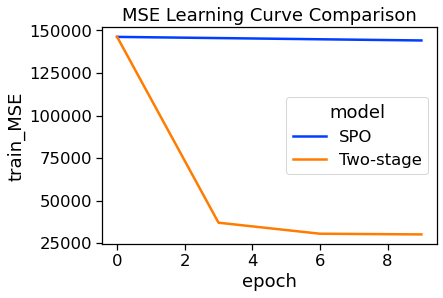

In [35]:
# This needs title: learning curve
sns.lineplot(y='train_MSE', x='epoch',
#                  markers=['o', 'v', 'D', 'P', 'X', 'h', 'H',  'd', '^', '8','<', '>', '*', 's', 'p',], 
             dashes=False,legend="full",
                 hue="model",palette=sns.color_palette('bright',n_colors=2),
             data = rslt_df).set_title("MSE Learning Curve Comparison")


Text(0.5, 1.0, 'Regret Learning Curve Comparison ')

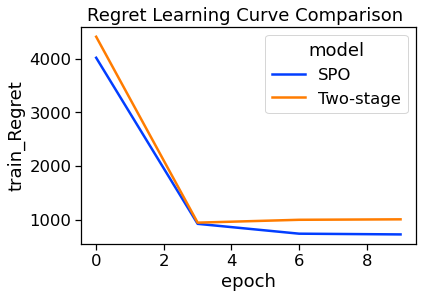

In [36]:
sns.lineplot(y='train_Regret', x='epoch',
#                  markers=['o', 'v', 'D', 'P', 'X', 'h', 'H',  'd', '^', '8','<', '>', '*', 's', 'p',], 
                 dashes=False,legend="full",
                 hue="model",palette=sns.color_palette('bright',n_colors=2),
                 data = rslt_df).set_title("Regret Learning Curve Comparison ")

## For a two-stage model even though MSE goes down, regret goes up
## For SPO, Regret goes down

### Now we examine the performance on test data.

In [37]:
rslt_df[rslt_df.epoch==9].groupby(['model']).agg({'test_Regret':['mean'],'test_MSE': ['mean'],'fit_time':['mean']  })

,test_Regret,test_MSE,fit_time
,mean,mean,mean
model,,,
SPO,737.539009,143795.787924,52.469133
Two-stage,972.689750,32179.587660,5.965457


## Because we repeatedly call solver while training SPO model, the model fitting time is high for SPO.

## We see, on test data, regret is significantly lower for SPO, confirming the superiority of this approach.